## Objective

Here, a baseline model is created using just 2D convolutional layers and MaxPooling to predict whether the cells are 'Uninfected' or 'Parasitized'.

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Standard imports

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *
from src.visualisation import *

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

## Create directory to merge all the images

In [0]:
#!unzip -q 'drive/My Drive/cell-images-for-detecting-malaria.zip'

In [0]:
# Create 'Combined' directory and copy all the png images over
# Note that the name 'Combined' must match that in the directory of the generator

#!mkdir Combined 
#!cp -a cell_images/cell_images/Parasitized/. Combined
#!cp -a cell_images/cell_images/Uninfected/. Combined

In [0]:
# Read from the csv 
df_train = pd.read_csv('drive/My Drive/data/malaria_train_combined.csv')
df_val = pd.read_csv('drive/My Drive/data/malaria_val_combined.csv')
df_test = pd.read_csv('drive/My Drive/data/malaria_test_combined.csv')

df_train['labels'] = df_train['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)

## Define generators and collect images from directory

In [0]:
# Create generators manually
train_datagen = ImageDataGenerator(
     rescale=1./255,
     shear_range=0.2,
     zoom_range=0.2,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     horizontal_flip=True)
  
val_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
# Get the generators
train_gen, valid_gen, test_gen = fit_into_generators(df_train,df_val,df_test,train_datagen, val_datagen,batch_size=32)

Found 19291 validated image filenames belonging to 2 classes.
Found 6199 validated image filenames belonging to 2 classes.
Found 2068 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="train_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="val_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## Inspect augmented images

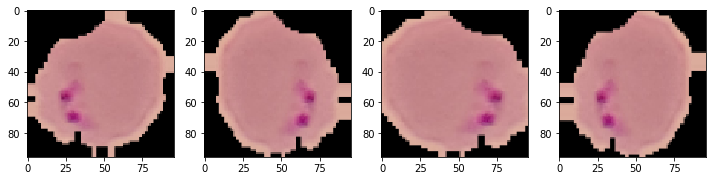

In [0]:
# Augmented versions of a particular sample
plot_augmented_images(train_gen,batch_index=2,sample_index=1)

- The above images correspond to augmented versions of a particular batch sample. 
- It can be observed that the images are reflected about the mid-vertical axis, sheared or even zoomed in.
- This allows the model to learn about focusing at the 'purple blobs' at different corners of the images.

## Create model architecture

In [0]:
# Create model
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_TEST=valid_gen.n//valid_gen.batch_size

# If no improvement in validation loss, we stop the training
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# If no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit_generator(train_gen, steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=20,
                   callbacks=[reducel, earlystopper])

Epoch 1/20
602/602 [==============================] - 98s 162ms/step - loss: 0.3709 - acc: 0.8430 - val_loss: 0.2108 - val_acc: 0.9309
Epoch 2/20
602/602 [==============================] - 88s 145ms/step - loss: 0.2108 - acc: 0.9451 - val_loss: 0.1654 - val_acc: 0.9499
Epoch 3/20
602/602 [==============================] - 87s 145ms/step - loss: 0.1942 - acc: 0.9469 - val_loss: 0.1955 - val_acc: 0.9293

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
602/602 [==============================] - 87s 144ms/step - loss: 0.1650 - acc: 0.9532 - val_loss: 0.1604 - val_acc: 0.9541
Epoch 5/20
602/602 [==============================] - 90s 149ms/step - loss: 0.1618 - acc: 0.9532 - val_loss: 0.1523 - val_acc: 0.9549
Epoch 6/20
602/602 [==============================] - 90s 150ms/step - loss: 0.1617 - acc: 0.9545 - val_loss: 0.1531 - val_acc: 0.9548

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/20
602/602 [======

In [0]:
#model.save_weights('baseline_weights_for_predicting_malaria.h5')

In [0]:
# Get the results
results = history.history

## Model Epoch Performances

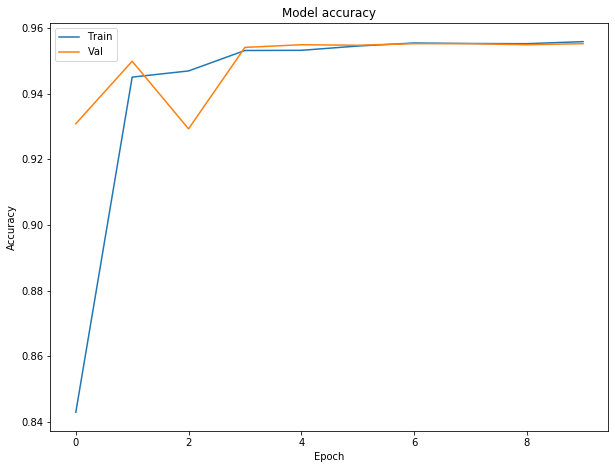

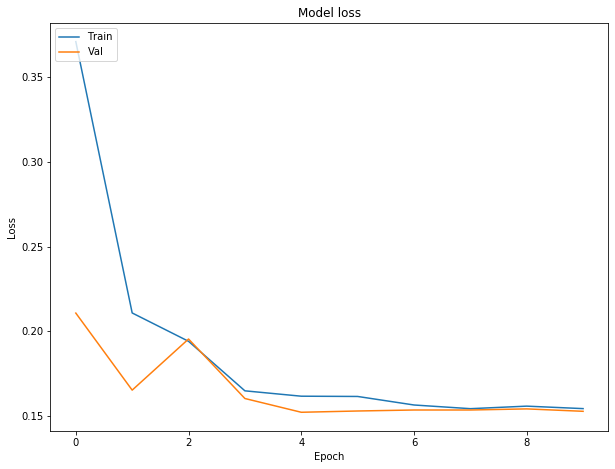

In [0]:
# summarize history for accuracy
plt.figure(figsize=(10,7.5))
plt.plot(results['acc'])
plt.plot(results['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,7.5))
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Based on the curves it seems that there is some underfitting near the start of the epoch, where the validation loss is lower than the training loss. After epoch 3, the curves stay close to each other.

## Evaluate model performance

In [0]:
model.evaluate_generator(test_gen)

[0.13494867413544331, 0.9550290134243624]

It seems that the model is performing similarly across the train, test and validation sets, with a pretty 'good' accuracy of ~95% accuracy. This shows that the train,test and val set created were of identical distribution. In the next notebook, we will dive deeper into what the model is actually learning or why is it making a particular prediction, be it right or wrong. After all, a good model might tend to learn the wrong features at times.